https://numbersandshapes.net/post/fitting_sir_to_data_in_python/

In [18]:
import numpy as np
import pandas as pd
import os, yaml, datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Lecture du fichier d'environnement
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR,
                         params['directories']['processed'],
                         params['files']['all_data'])

# Lecture du fichier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df: _df['Last Update'].dt.date).drop('Last Update', axis=1)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020, 3, 13)])


In [20]:
epidemie_df.head() 

,Province/State,Country/Region,Confirmed,Deaths,Recovered,Latitude,Longitude,source,day
0,Hubei,Mainland China,65187.0,2615.0,20969.0,30.9756,112.2707,02-26-2020.csv,2020-02-26
1,Guangdong,Mainland China,1347.0,7.0,851.0,23.3417,113.4244,02-26-2020.csv,2020-02-26
2,Henan,Mainland China,1271.0,19.0,1033.0,33.8820,113.6140,02-26-2020.csv,2020-02-26
3,NaN,South Korea,1261.0,12.0,22.0,36.0000,128.0000,02-26-2020.csv,2020-02-26
4,Zhejiang,Mainland China,1205.0,1.0,867.0,29.1832,120.0934,02-26-2020.csv,2020-02-26


In [21]:
def country_df(country):
    
    df = (epidemie_df[epidemie_df['Country/Region'] == country]
          .drop_duplicates(subset=['Province/State','day','Latitude','Longitude'])
          .groupby(by=['Country/Region', 'day'])
          .agg({'Confirmed':'sum', 'Deaths':'sum','Recovered':'sum'})
          .reset_index())
    return df

# Monkey patch pd.DataFrame
pd.DataFrame.country_df = country_df 
france_df = country_df('France')

In [22]:
def get_country(self, country):
    # self: le 1er element dans la founction (dans notre cas epidemie_df)
    return (epidemie_df[epidemie_df['Country/Region']==country]
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'})
             .reset_index())

# Monkey patch pd.DataFrame
pd.DataFrame.get_country = get_country 

In [23]:
korea_df = get_country(epidemie_df, 'South Korea')
italy_df = get_country(epidemie_df, 'Italy')
france_df = get_country(epidemie_df, 'France')

In [24]:
korea_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
38,South Korea,2020-03-05,6088.0,35.0,41.0
39,South Korea,2020-03-06,6593.0,42.0,135.0
40,South Korea,2020-03-07,7041.0,44.0,135.0
41,South Korea,2020-03-08,7314.0,50.0,118.0
42,South Korea,2020-03-09,7478.0,53.0,118.0


SIR: S = susceptible, I = Infected, R = Recovered  
I = I_t-I_(t-1)

In [25]:
korea_df['infected'] = korea_df['Confirmed'].diff()
italy_df['infected'] = italy_df['Confirmed'].diff()
france_df['infected'] = france_df['Confirmed'].diff()

In [26]:
def plot_curve(data, counties):
    
    fig = plt.figure(figsize=(16,7))
    for df, country in zip(data, counties):   
        plt.plot(df['day'], df['Confirmed'], label=country+': confirmed')
        plt.plot(df['day'], df['infected'], label=country+': infected')
    
    plt.title('Country comparison curves', fontsize=27)
    plt.legend(fontsize=14)
    plt.grid(True)
    return plt.show()

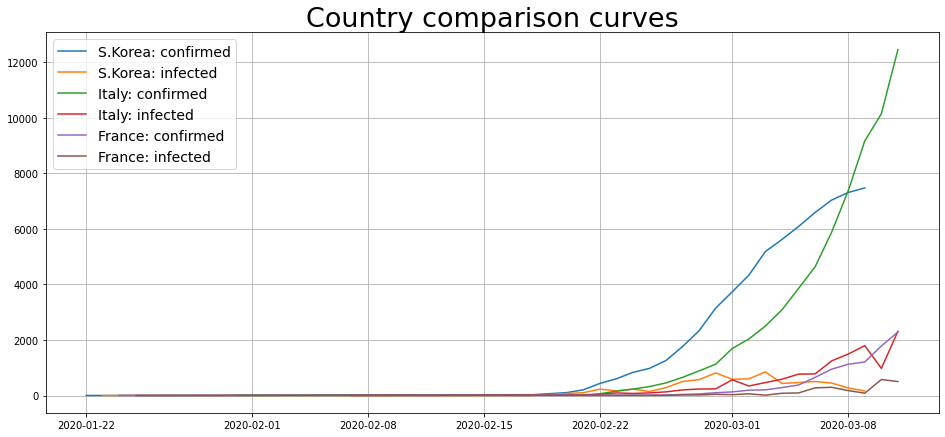

In [27]:
counties = ['S.Korea','Italy', 'France']
df = [korea_df, italy_df, france_df]
plot_curve(df, counties)

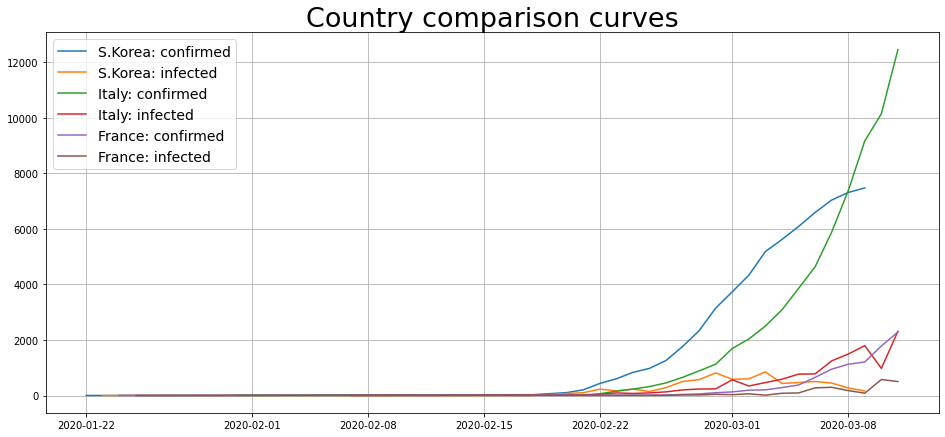

In [28]:
counties = ['S.Korea','Italy', 'France']
df = [korea_df, italy_df, france_df]
plot_curve(df, counties)

## Application du modèle SIR aux données Corona

In [29]:
def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

This [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function numerically integrates a system of ordinary differential equations given an initial value.

In [31]:
from scipy.integrate import solve_ivp
beta, gamma = [0.001,0.1]

solution_korea = solve_ivp(SIR, [0, 27], [51_470_000, 1, 0], t_eval=np.arange(0, 27, 1))

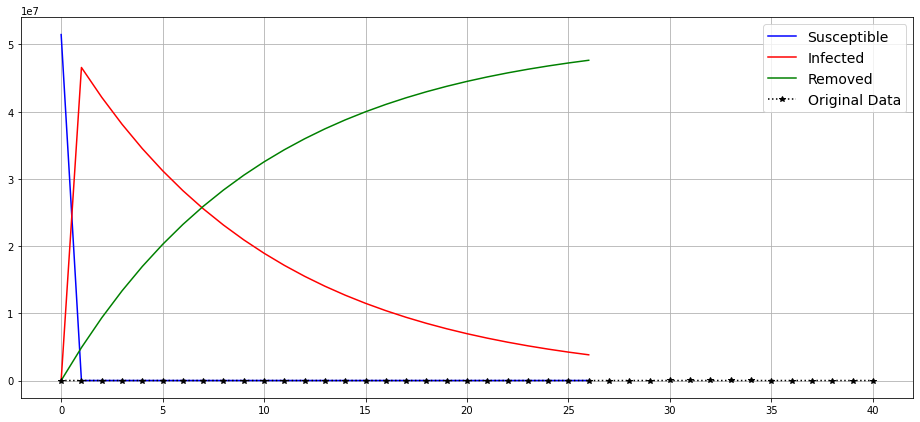

In [32]:
def plot_epidemia(solution, infected):
    
    fig = plt.figure(figsize=(16,7))
    plt.plot(solution.t, solution.y[0],"b-")
    plt.plot(solution.t, solution.y[1],"r-")
    plt.plot(solution.t, solution.y[2],"g-")
    
    plt.plot(infected.reset_index(drop=True).index, infected,"k*:")
    
    plt.legend(["Susceptible","Infected","Removed","Original Data"], fontsize=14)
    plt.grid('True')
    plt.show()
    
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [33]:
def sumsq_error(p):
    beta, gamma = p
    def SIR(t, y):
        S = y[0]; I = y[1]; R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

    sol = solve_ivp(SIR, [0, nb_steps], [total_population, 1, 0], t_eval=np.arange(0, nb_steps, 1))
    
    return(sum((sol.y[1]-infected_population)**2))


In [34]:
total_population = 51_470_000
infected_population = korea_df['infected'][27:]
nb_steps = len(infected_population)

In [35]:
%%time 
from scipy.optimize import minimize

msol = minimize(sumsq_error, [0.001, 0.1], method='Nelder-Mead')

CPU times: user 8min 48s, sys: 2.32 s, total: 8min 51s
Wall time: 8min 53s


In [206]:
msol.x

array([ 0.02383221, 12.31619556])

In [ ]:
beta, gamma = msol.x
# function, interval de temps, subceptible(pop total)
solution_korea = solve_ivp(SIR, [0, nb_steps], [51_470_000, 1, 0], t_eval=np.arange(0, nb_steps, 1))

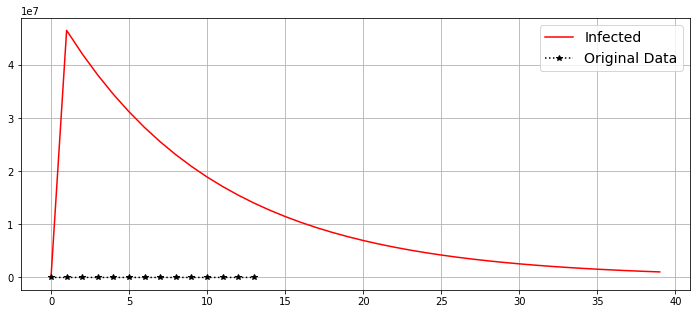

In [21]:
def plot_epidemia(solution, infected):
    
    fig = plt.figure(figsize=(12,5))

    #plt.plot(solution.t, solution.y[0],"b-")
    plt.plot(solution.t, solution.y[1],"r-")
    #plt.plot(solution.t, solution.y[2],"g-")
    plt.plot(infected.reset_index(drop=True).index, infected,"k*:")
    plt.legend(["Infected","Original Data"], fontsize=14)
    plt.grid('True')
    plt.show()
    
plot_epidemia(solution_korea, korea_df.loc[29:]['infected'])

In [22]:
china_df = epidemie_df.get_country('Mainland China').loc[:48]
china_df['infected'] = china_df['Confirmed'].diff()
china_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
44,Mainland China,2020-03-06,79771.0,3029.0,53172.0,306.0
45,Mainland China,2020-03-07,78619.0,3051.0,53511.0,-1152.0
46,Mainland China,2020-03-08,79455.0,3084.0,56114.0,836.0
47,Mainland China,2020-03-09,76902.0,3071.0,55004.0,-2553.0
48,Mainland China,2020-03-10,77201.0,3088.0,56620.0,299.0


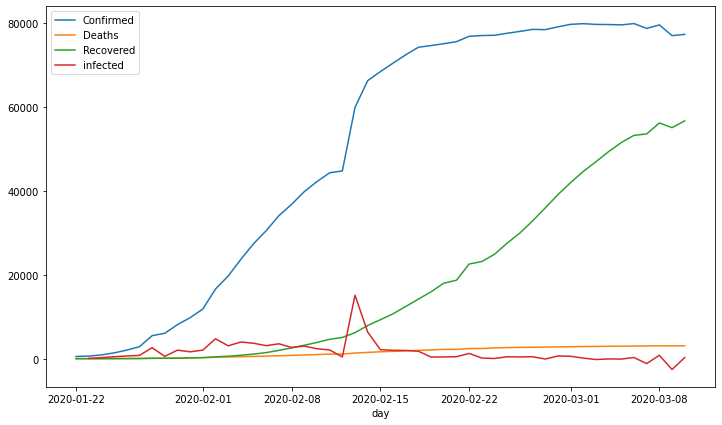

In [23]:
china_df.set_index('day').plot.line(figsize=(12,7))

In [24]:
%%time
beta, gamma = 0.001, 0.1

total_population = 1_350_000_000
infected_population = china_df.loc[2:]['infected']
nb_steps = len(infected_population)

solution_china = solve_ivp(SIR, [0, 40], [1_350_000_000, 1, 0], t_eval=np.arange(0, 40, 1))

KeyboardInterrupt: 

In [ ]:
def plot_epidemia(solution, infected):
    
    fig = plt.figure(figsize=(12,5))

    #plt.plot(solution.t, solution.y[0],"b-")
    plt.plot(solution.t, solution.y[1],"r-", labe)
    #plt.plot(solution.t, solution.y[2],"g-")
    plt.plot(infected.reset_index(drop=True).index, infected,"k*:")
    plt.legend(["Infected","Original Data"], fontsize=14)
    plt.grid('True')
    plt.show()
    
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [568]:
epidemie_df['day'].unique()

array([datetime.date(2020, 2, 26), datetime.date(2020, 2, 25),
       datetime.date(2020, 2, 24), datetime.date(2020, 2, 21),
       datetime.date(2020, 2, 22), datetime.date(2020, 2, 13),
       datetime.date(2020, 2, 16), datetime.date(2020, 2, 12),
       datetime.date(2020, 2, 17), datetime.date(2020, 2, 9),
       datetime.date(2020, 2, 3), datetime.date(2020, 2, 8),
       datetime.date(2020, 2, 1), datetime.date(2020, 2, 5),
       datetime.date(2020, 2, 27), datetime.date(2020, 2, 18),
       datetime.date(2020, 2, 15), datetime.date(2020, 2, 7),
       datetime.date(2020, 2, 4), datetime.date(2020, 2, 14),
       datetime.date(2020, 2, 19), datetime.date(2020, 3, 10),
       datetime.date(2020, 3, 8), datetime.date(2020, 3, 6),
       datetime.date(2020, 3, 7), datetime.date(2020, 3, 9),
       datetime.date(2020, 3, 2), datetime.date(2020, 3, 1),
       datetime.date(2020, 3, 3), datetime.date(2020, 3, 4),
       datetime.date(2020, 2, 28), datetime.date(2020, 2, 29),
       

In [ ]:
# Population data for Model SIR
pop_df = pd.DataFrame(index=['France','Italy','Spain', 'Korea', 'China'], 
                      data=[66190280,60484505,46750139,51257871,1384688986], 
                      columns=['population'])

parameters = pd.DataFrame([np.arange(0.05, 1.0, 0.2), np.arange(0.05, 1.0, 0.2)], index=['beta', 'gamma']).T